## Oxparis Visualization Notebook
In this notebook one can load images and gt from the oxparis dataset as given by the POLD2 team (they were givin it by remi).
Possible actions in this Notebook:
- Load Images from the dataset and look at it and GT
- Run model on image and compare result with gt
- also detect lines

In [1]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
from gluefactory.datasets import get_dataset

line_neighborhood = 5 # in px used to nortmalize/ denormalize df

Define utility functions

In [2]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def normalize_df(df):
    return -torch.log(df / line_neighborhood + 1e-6)

def denormalize_df(df_norm):
    return torch.exp(-df_norm) * line_neighborhood

def visualize_img_with_gt(dset, num=5, offset=0, lim_kpoints=-1):
    idxs = list(range(offset, offset+num, 1))
    _, ax = plt.subplots(len(idxs), 4, figsize=(20, num*4))
    for i in idxs:
        elem = dset[i]
        af = elem["deeplsd_angle_field"]
        df = elem["deeplsd_distance_field"]
        hmap = elem["superpoint_heatmap"]
        orig_pt = elem["gt_keypoints"]
        
        ax[i, 0].axis('off')
        ax[i, 0].set_title('Heatmap')
        ax[i, 0].imshow(hmap)

        ax[i, 1].axis('off')
        ax[i, 1].set_title('Distance Field')
        ax[i, 1].imshow(df)

        ax[i, 2].axis('off')
        ax[i, 2].set_title('Angle Field')
        ax[i, 2].imshow(get_flow_vis(df, af))

        ax[i, 3].axis('off')
        ax[i, 3].set_title('Original')
        ax[i, 3].imshow(elem["image"].permute(1,2,0))
        ax[i, 3].scatter(orig_pt[:lim_kpoints, 0], orig_pt[:lim_kpoints, 1], marker="o", color="red", s=3)
    plt.show()
    

In [3]:
dset_conf = {
            "reshape": 800,  # ex. 800
            "multiscale_learning": {
                "do": False,
                "scales_list": [800, 600, 400],
                "scale_selection": 'round-robin' # random or round-robin
            },
            "load_features": {
                "do": True,
                "check_exists": True,
                "point_gt": {
                    "data_keys": ["superpoint_heatmap"],
                    "use_score_heatmap": False,
                },
                "line_gt": {
                    "data_keys": ["deeplsd_distance_field", "deeplsd_angle_field"],
                },
            },
            "debug": True
        }
loaded_ds = get_dataset("oxford_paris_mini_1view_jpldd")(dset_conf)
ds = loaded_ds.get_dataset(split="train")

# load one test element
elem = ds[0]
print(f"Img-Shape: {elem['image'].shape}")
print(f"Keys: {elem.keys()}")

# print example shapes
af = elem["deeplsd_angle_field"]
df = elem["deeplsd_distance_field"]
hmap = elem["superpoint_heatmap"]
orig_pt = elem["gt_keypoints"]
print(orig_pt)

print(f"AF: type: {type(af)}, shape: {af.shape}, min: {torch.min(af)}, max: {torch.max(af)}")
print(f"DF: type: {type(df)}, shape: {df.shape}, min: {torch.min(df)}, max: {torch.max(df)}")
print(f"KP-HMAP: type: {type(hmap)}, shape: {hmap.shape}, min: {torch.min(hmap)}, max: {torch.max(hmap)}, sum: {torch.sum(hmap)}")

[10/16/2024 00:28:35 gluefactory.datasets.base_dataset INFO] Creating dataset OxfordParisMiniOneViewJPLDD
[10/16/2024 00:28:35 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES: 12000
[10/16/2024 00:28:35 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] KNOWN BATCHSIZE FOR MY SPLIT(train) is 2


DATASET OVERALL(NO-SPLIT) IMAGES: 12000


[10/16/2024 00:28:36 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES WITH GT: 12000


Img-Shape: torch.Size([3, 800, 800])
Keys: dict_keys(['name', 'scales', 'image_size', 'transform', 'original_image_size', 'image', 'padding_mask', 'superpoint_heatmap', 'gt_keypoints', 'gt_keypoints_scores', 'deeplsd_distance_field', 'deeplsd_angle_field'])
tensor([[4.6231e+02, 5.3986e-01],
        [5.2175e+02, 2.8971e-01],
        [5.2847e+02, 2.3665e-01],
        ...,
        [7.6866e+02, 5.9708e+02],
        [7.8879e+02, 5.9753e+02],
        [7.9457e+02, 5.9796e+02]])
AF: type: <class 'torch.Tensor'>, shape: torch.Size([800, 800]), min: 0.0, max: 3.1415927410125732
DF: type: <class 'torch.Tensor'>, shape: torch.Size([800, 800]), min: 0.0, max: 5.0
KP-HMAP: type: <class 'torch.Tensor'>, shape: torch.Size([800, 800]), min: 0.0, max: 0.9604514241218567, sum: 680.149169921875


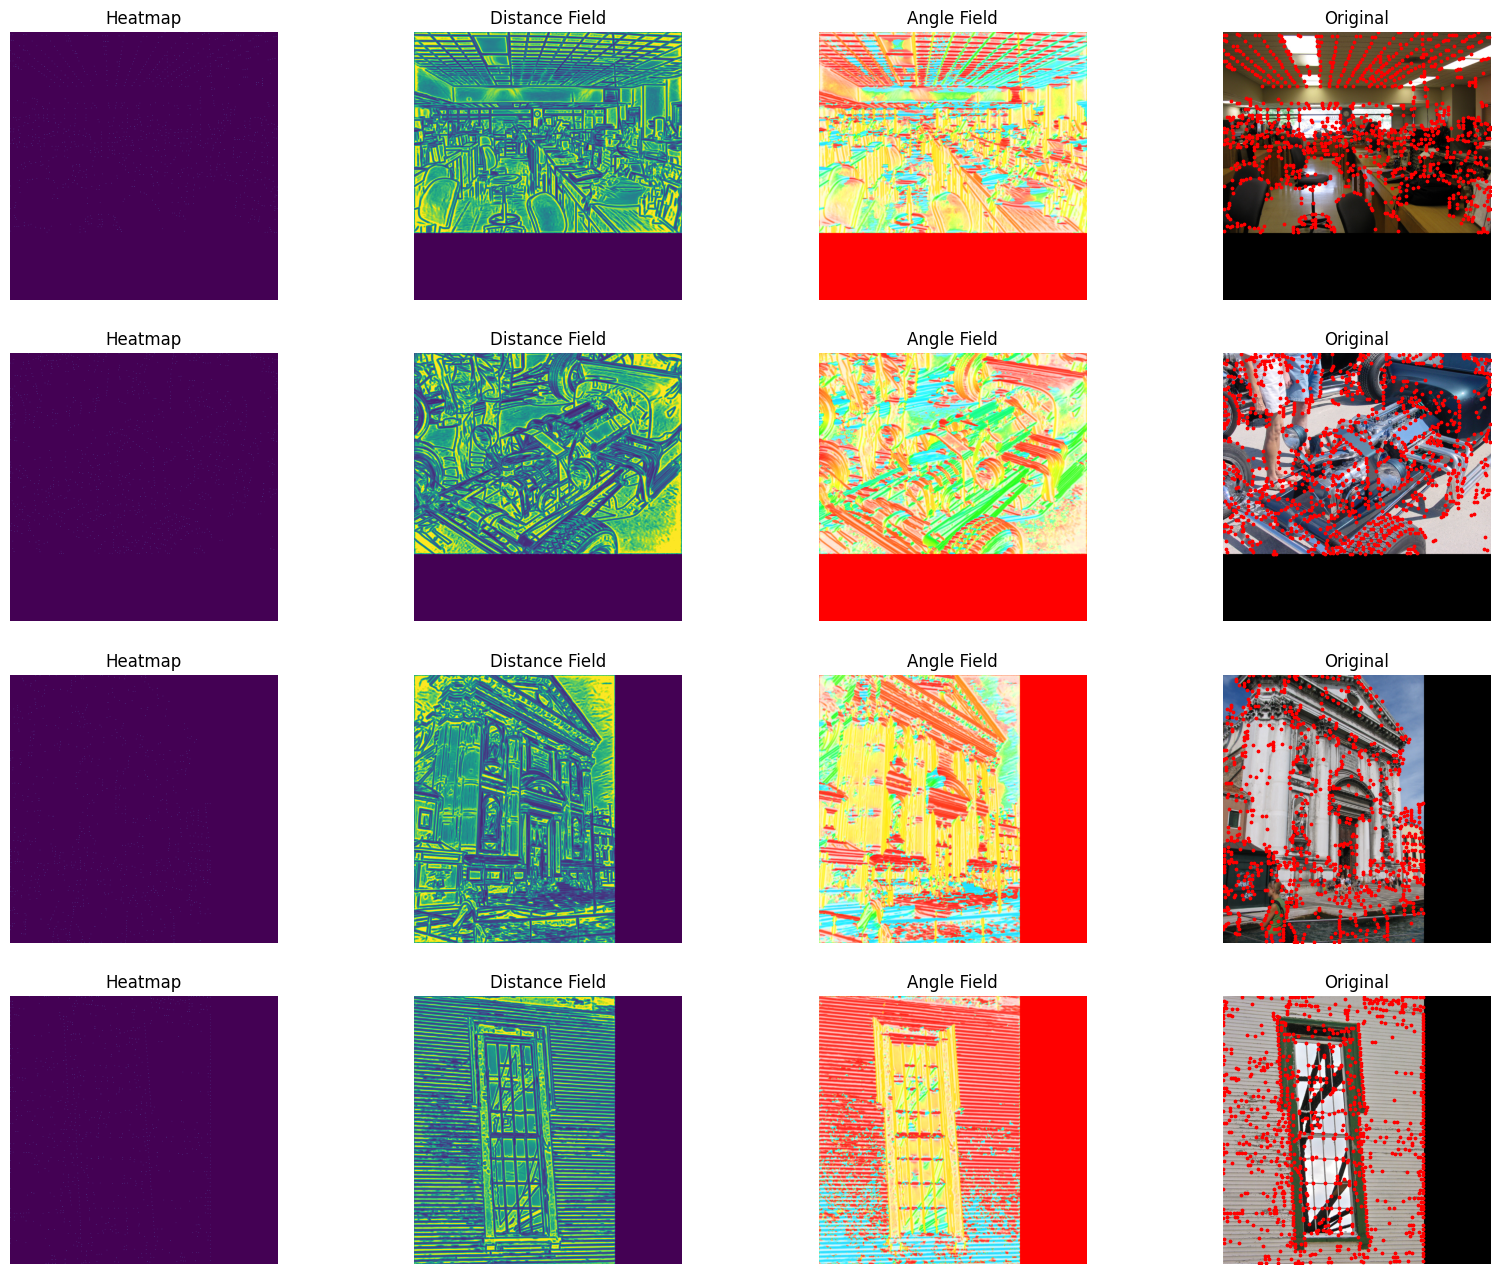

In [4]:
visualize_img_with_gt(ds, num=4)

## Run a model to get predictions

Define utility for visualisation and example calculation

In [5]:
def compute_and_visualize(img_data_with_gt, model, device):
    img_torch = img_data_with_gt["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = model({"image": img_torch})
    jpldd_kpjhm = output_model['keypoint_and_junction_score_map'][0].cpu()
    jpldd_af = output_model['line_anglefield'][0].cpu()
    jpldd_df = output_model['line_distancefield'][0].cpu()
    jpldd_kp = output_model['keypoints'][0].cpu()
        
    af_gt = img_data_with_gt["deeplsd_angle_field"].cpu()
    df_gt = img_data_with_gt["deeplsd_distance_field"].cpu()
    hmap_gt = img_data_with_gt["superpoint_heatmap"].cpu()
    orig_pt_gt = img_data_with_gt["gt_keypoints"].cpu()
    
    _, ax = plt.subplots(2, 4, figsize=(20, 8))
    ax[0, 0].axis('off')
    ax[0, 0].set_title('GT-Heatmap')
    ax[0, 0].imshow(hmap_gt)

    ax[0, 1].axis('off')
    ax[0, 1].set_title('GT-Distance Field')
    ax[0, 1].imshow(df_gt)

    ax[0, 2].axis('off')
    ax[0, 2].set_title('GT-Angle Field')
    ax[0, 2].imshow(get_flow_vis(df_gt, af_gt))

    ax[0, 3].axis('off')
    ax[0, 3].set_title('GT-Original')
    ax[0, 3].imshow(img_data_with_gt["image"].permute(1,2,0))
    ax[0, 3].scatter(orig_pt_gt[:, 0], orig_pt_gt[:, 1], marker="o", color="red", s=3)
    
    ax[1, 0].axis('off')
    ax[1, 0].set_title('KP&J Heatmap')
    ax[1, 0].imshow(jpldd_kpjhm)

    ax[1, 1].axis('off')
    ax[1, 1].set_title('Distance Field')
    ax[1, 1].imshow(jpldd_df)

    ax[1, 2].axis('off')
    ax[1, 2].set_title('Angle Field')
    ax[1, 2].imshow(get_flow_vis(jpldd_df, jpldd_af))

    ax[1, 3].axis('off')
    ax[1, 3].set_title('Original w. detected kp')
    ax[1, 3].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
    ax[1, 3].scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], marker="o", color="red", s=3)
    plt.show()
    return output_model

In [6]:
from gluefactory.models import get_model

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
print(f"Device Used: {device}")

jpldd_conf = {
    "name": "joint_point_line_extractor",
    "max_num_keypoints": 500,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": True,
        "conf": {
            "num_sample": 8,
            "num_sample_strong": 150,
            "max_point_size": 1500,

        "distance_map": {
            "threshold": 0.5,
            "avg_filter_size": 13,
            "avg_filter_padding": 6,
            "avg_filter_stride": 1,
            "max_value": 5,
            "inlier_ratio": 0.8,
            "max_accepted_mean_value": 0.4
        },

        "mlp_conf": {
            "has_angle_field": True,
            "has_distance_field": True, 
            "num_line_samples": 150,    # number of sampled points between line endpoints
            "mlp_hidden_dims": [256, 128, 128, 64, 32],
            "pred_threshold": 0.9,
            "weights": "/local/home/Point-Line/outputs/training/pold2_mlp_gen+train_run1/checkpoint_best.tar",
        }
        }
    },
    "checkpoint": "/local/home/rkreft/shared_team_folder/outputs/training/focal_loss_experiments/rk_focal_threshDF_focal/checkpoint_best.tar"
    #"checkpoint": "/local/home/rkreft/shared_team_folder/outputs/training/rk_pold2gt_oxparis_base_hard_gt/checkpoint_best.tar"
}
jpldd_model = get_model("joint_point_line_extractor")(jpldd_conf).to(device)
jpldd_model.eval()

Device Used: cuda


[10/16/2024 00:29:08 gluefactory.models.lines.pold2_mlp INFO] Successfully loaded model weights from /local/home/Point-Line/outputs/training/pold2_mlp_gen+train_run1/checkpoint_best.tar
Load model parameters from checkpoint /local/home/rkreft/shared_team_folder/outputs/training/focal_loss_experiments/rk_focal_threshDF_focal/checkpoint_best.tar
/local/home/rkreft/glue-factory/gluefactory/models/extractors/joint_point_line_extractor.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded v

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

### Compute and visualize
Prediction and groundtruth for a given image

NO LINES DETECTED


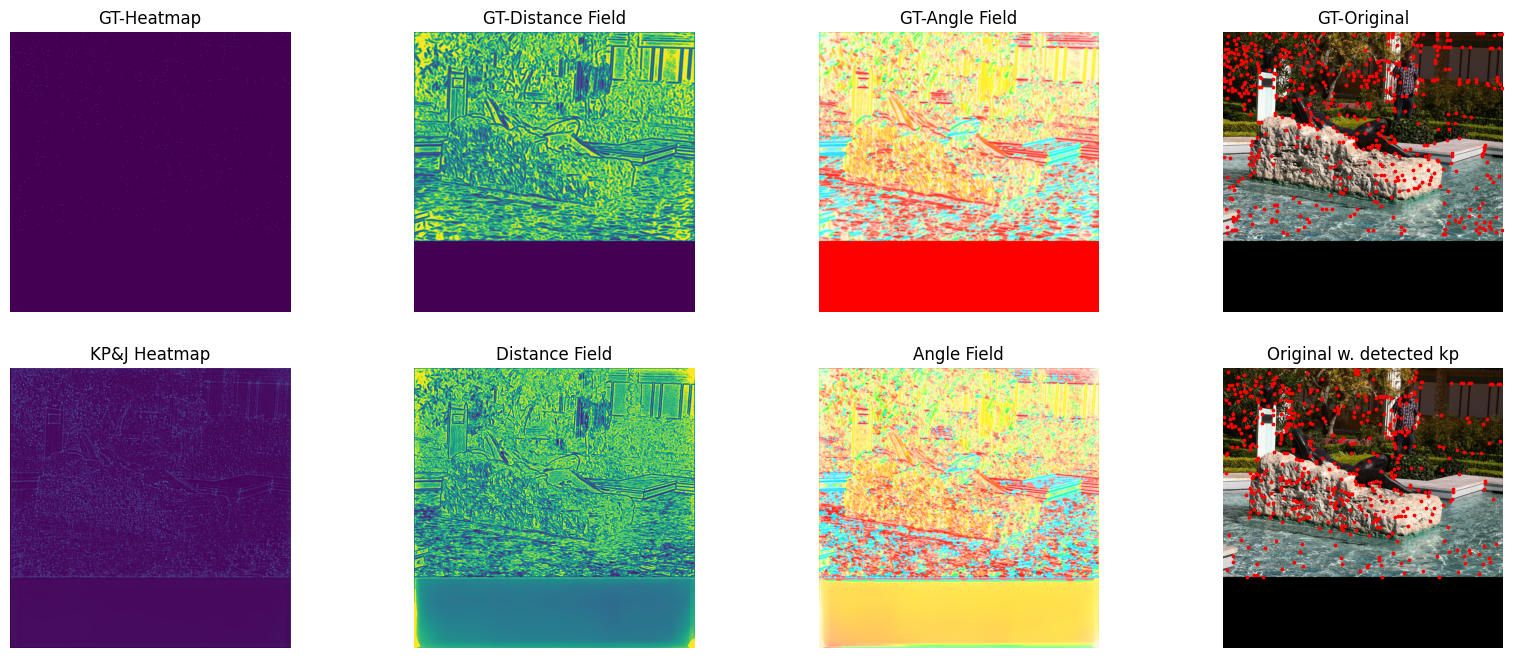

DF: type: <class 'torch.Tensor'>, shape: torch.Size([1, 800, 800]), min: 0.7678614854812622, max: 5.0


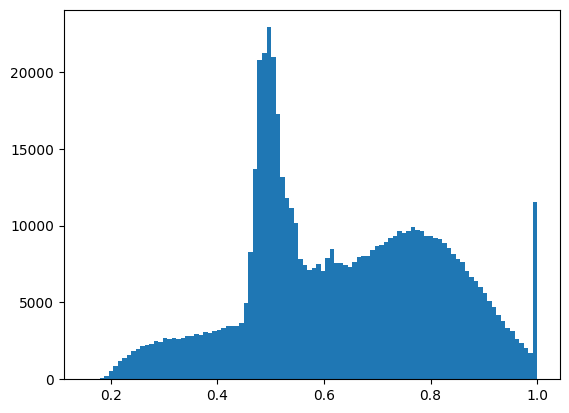

tensor([[[ 27.0338, 131.1640],
         [104.1302,  24.0300],
         [ 64.0801, 167.2090],
         [161.2015,  92.1151],
         [ 17.0213, 475.5945],
         [ 78.0976, 127.1590],
         [ 58.0726, 220.2754],
         [163.2040,  61.0764],
         [204.2553, 165.2065],
         [730.9136, 586.7335],
         [489.6120, 228.2854],
         [ 91.1139,  47.0588],
         [315.3942, 272.3404],
         [534.6683, 333.4168],
         [316.3955, 120.1502],
         [141.1765, 158.1977],
         [111.1389, 131.1640],
         [504.6308,  85.1064],
         [549.6871,  91.1139],
         [524.6558, 182.2278],
         [484.6057, 314.3930],
         [328.4105, 281.3517],
         [ 45.0563, 174.2178],
         [148.1852,  98.1226],
         [110.1377, 157.1965],
         [434.5432, 431.5394],
         [534.6683, 339.4243],
         [138.1727,  52.0651],
         [192.2403, 127.1590],
         [568.7109,  39.0488],
         [109.1364,  68.0851],
         [415.5194, 329.4118],
        

In [10]:
output_model = compute_and_visualize(ds[5], jpldd_model, device)
df = output_model["line_distancefield"]
print(f"DF: type: {type(df)}, shape: {df.shape}, min: {torch.min(df)}, max: {torch.max(df)}")
df_cpu = df.to("cpu")
df_normalized = df_cpu / df_cpu.max()
plt.hist(df_normalized.flatten(), bins=100)
plt.show()
print(output_model["keypoints"])

## Timings
Here we run some fw passes for single images and print timings. Check settings of model and dataset to interpret results correctly. Results are given as mean seconds.

In [8]:
from pprint import pprint
import random

rand_idx = random.sample(range(0, len(ds)), 300) 

for i in rand_idx:
    img_torch = ds[i]["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = jpldd_model({"image": img_torch})

timings=jpldd_model.get_current_timings(reset=True)
pprint(timings)
print(f"~FPS: {1 / (timings['total-makespan'])} using device {device}")

NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES DETECTED
NO LINES D